In [1]:
# from langchain_openai import ChatOpenAI
from customchatmodel import CustomChatModel

from langchain_core.messages import HumanMessage,AIMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain.prompts import PromptTemplate
from IPython.display import display, Image
from typing import Annotated, Literal
from langchain_ollama import ChatOllama

from typing_extensions import TypedDict
from langchain.tools import tool
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
    SystemMessage
)
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_core.utils.function_calling import convert_to_openai_tool

class State(MessagesState):
    next: str

model = CustomChatModel(model="gemma3:12b")
memory = MemorySaver()

# Create specialized agents

@tool
def add(a: Annotated[float, "This is the first number to be added"], b: Annotated[float, "This is the second number to be added"]) -> float:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: Annotated[float, "This is the first number to be multiplied"], b: Annotated[float, "This is the second number to be multiplied"]) -> float:
    """Multiply two numbers."""
    return a * b

@tool
def web_search(query: Annotated[str, "This input will be used to search the web"]) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=CustomChatModel(model="gemma3:12b"),
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. You can only answer math related queries such as adding and multiplying. Always use one tool at a time."
)

def math_node(state: State) -> Command[Literal["supervisor"]]:
    tool_instructions = str(convert_to_openai_tool(tool)) + "\n"

    system_prompt = f"""\
            You are an assistant that has access to the following set of tools. 
            Here are the names and descriptions for each tool:

            {tool_instructions}

            Given the user input, return the name and input of the tool to use. 
            Return your response as a JSON blob with 'name' and 'arguments' keys.

            The `arguments` should be a dictionary, with keys corresponding 
            to the argument names and the values corresponding to the requested values.
            """

    result = math_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="math_agent")
            ]
        },
        goto="supervisor",
    )

research_agent = create_react_agent(
    model=CustomChatModel(model="gemma3:12b"),
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="research_agent")
            ]
        },
        goto="supervisor",
    )

# Create supervisor workflow
members = ["research_agent", "math_agent"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next under 'arguments'. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH under 'arguments'"


    "Guidelines:\n"
    "1. Always check the last message in the conversation to determine if the task has been completed.\n"
    "2. If you already have the final answer or outcome, return 'FINISH'.\n"
   
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

def supervisor_node(state: State)-> Command[Literal[*members, "__end__"]]:
    messages = [
        SystemMessage(content=system_prompt),
    ] + state["messages"]
    response = model.invoke(messages)
    # response = model.with_structured_output(Router).invoke(messages)
    # goto = response["next"]
    goto = response.tool_calls[0]["name"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# Compile and run
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("math_agent", math_node)
builder.add_node("research_agent", research_node)
graph = builder.compile(checkpointer=memory)

C:\Users\lonyi\AppData\Local\Temp\ipykernel_6720\990487923.py:2: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from customchatmodel import CustomChatModel


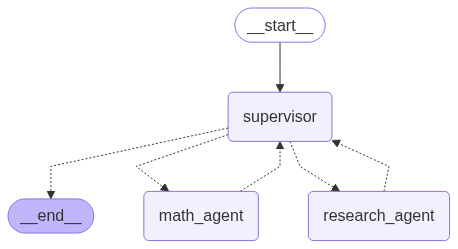

In [2]:
graph

In [3]:
def parse_langgraph_output(stream):
    results = []
    for key, value in stream.items():
        if key == "supervisor":
            continue
        messages = value.get("messages", [])
        for msg in messages:
            if isinstance(msg, str):
                results.append((key, msg))
            elif isinstance(msg, AIMessage):
                results.append((key, msg.content))
    return results

In [ ]:
# Get the final step in the stream
final_event = None
config = {"configurable": {"thread_id": "1", "recursion_limit": 10}}    
inputs = {
                "messages": [
                    HumanMessage(
                        content="what's the combined headcount of the FAANG companies in 2024?"
                    )
                ],
            }


for step in graph.stream(inputs, config=config):
    final_event = step  # Keep updating to the latest step
    print(final_event)

    response_message=parse_langgraph_output(final_event)
    for agent, content in response_message:
        print(f"**Agent :** `{agent}`\n\n{content}")
        print("="*50)

INFO:customchatmodel:Messages string:             You are an assistant that has access to the following set of tools. 
            Here are the names and descriptions for each tool:

            

            Given the user input, return the name and input of the tool to use. 
            Return your response as a JSON blob with 'name' and 'arguments' keys.

            The `arguments` should be a dictionary, with keys corresponding 
            to the argument names and the values corresponding to the requested values.
            
You are a supervisor tasked with managing a conversation between the following workers: ['research_agent', 'math_agent']. Given the following user request, respond with the worker to act next under 'arguments'. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH under 'arguments'Guidelines:
1. Always check the last message in the conversation to determine if the task has been completed.
2. If you alr

{'supervisor': {'next': 'research_agent'}}


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:customchatmodel:Response type: <class 'str'>
INFO:customchatmodel:Response: content='' additional_kwargs={} response_metadata={'time_in_seconds': 3, 'model_name': 'gemma3:12b'} tool_calls=[{'name': 'web_search', 'args': {'query': 'FAANG company headcount 2024'}, 'id': 'call_9c8c401defa34124a96bbdc45a70c669', 'type': 'tool_call'}]
INFO:customchatmodel:Messages string:             You are an assistant that has access to the following set of tools. 
            Here are the names and descriptions for each tool:

            {'type': 'function', 'function': {'name': 'web_search', 'description': 'Search the web for information.', 'parameters': {'properties': {'query': {'description': 'This input will be used to search the web', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}


            Given the user input, return the name and input of the tool to use. 
            Return your response